In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# internal imports
from pympc.control.hybrid_benchmark.mixed_logical_dynamical_system import MixedLogicalDynamicalSystem
from pympc.control.hybrid_benchmark.controller_mld import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_output_trajectory

In [2]:
# system numeric parameters
mc = 1.
mp = 1.
l = 1.
d = 1.
k = 100.
g = 10.
h = .05

# state bounds
x_max = np.array([d, np.pi/6., 7., 5.])
x_min = - x_max

# input domain
u_max = np.array([20.])
u_min = - u_max

In [3]:
# symbolic states
x = sp.Matrix(sp.symbols('q t qd td'))

# symbolic continuous inputs
u = sp.Matrix([sp.symbols('u')])

# symbolic binary inputs
ub = sp.zeros(0,1)

# symbolic forces (left, right)
f = sp.Matrix(sp.symbols('fl fr'))

# symbolic auxiliary binaries (left, right)
b = sp.Matrix(sp.symbols('bl br'))

# dynamics
x_next = sp.Matrix([
    x[0] + h*x[2],
    x[1] + h*x[3],
    x[2] + h*((g*mp)/mc*x[1] + u[0]/mc),
    x[3] + h*(g*(mc+mp)/(l*mc)*x[1] + u[0]/(l*mc) - f[0]/(l*mp) + f[1]/(l*mp))
])

In [4]:
# state bounds
state_upper_bound = x - x_max.reshape(x_max.size, 1)
state_lower_bound = x_min.reshape(x_min.size, 1) - x

# input bounds
input_upper_bound = u - u_max.reshape(u_max.size, 1)
input_lower_bound = u_min.reshape(u_min.size, 1) - u

# contact left wall (big-M method)
# positive penetration: - d - x[0] + l*x[1]
left_force = sp.Matrix([
    - f[0],
    k*(- d - x[0] + l*x[1]) - f[0],
    f[0] - b[0]*k*(- d - x_min[0] + l*x_max[1]),
    f[0] - k*(- d - x[0] + l*x[1]) + (1. - b[0])*k*(- d - x_max[0] + l*x_min[1])
])

# contact right wall (big-M method)
# positive penetration: x[0] - l*x[1] - d
right_force = sp.Matrix([
    - f[1],
    k*(x[0] - l*x[1] - d) - f[1],
    f[1] - b[1]*k*(x_max[0] - l*x_min[1] - d),
    f[1] - k*(x[0] - l*x[1] - d) + (1. - b[1])*k*(x_min[0] - l*x_max[1] - d)
])

# gather constraints
constraints = sp.Matrix([
    state_upper_bound,
    state_lower_bound,
    input_upper_bound,
    input_lower_bound,
    left_force,
    right_force
])

In [5]:
# construct MLD system
variables = {'x':x, 'uc':u, 'ub':ub, 'sc':f, 'sb':b}
MLD = MixedLogicalDynamicalSystem.from_symbolic(variables, x_next, constraints)

In [6]:
# controller parameters
N = 20
weight_matrices = {}
weight_matrices['Q'] = 10.*np.eye(MLD.nx)*h/2.
weight_matrices['R'] = .1*np.eye(MLD.nuc)*h/2.
weight_matrices['P'] = weight_matrices['Q']#*100.

# hybrid controller
controller = HybridModelPredictiveController(MLD, N, weight_matrices)

Academic license - for non-commercial use only


In [7]:
x0 = np.array([0., 0., 2.5, 0.])
# x0 = np.array([0.44366632, 0.06866632, 2.94079905, 0.45738834])

# try controller open loop

In [8]:
cost, sol, leaves = controller.feedforward(x0, tree_file_name='tau_eq_0')

|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.055            1                4.362            inf             
  New incumbent    2.448            124              38.914           38.914          
  Solution found   2.471            125              38.914           38.914          

Explored 125 nodes in 2.471 seconds: optimal solution found with objective 38.914.


In [9]:
np.random.seed(1)
e_max = 0.0
e_0 = e_max * np.random.randn(MLD.nx)
x_1 = sol['primal']['x'][1] + e_0
print e_0

[ 0. -0. -0. -0.]


In [32]:
stage_variables = {
    'x_0' : sol['primal']['x'][0],
    'uc_0' : sol['primal']['uc'][0],
    'ub_0' : sol['primal']['ub'][0],
    'sc_0' : sol['primal']['sc'][0],
    'sb_0' : sol['primal']['sb'][0],
    'e_0' : e_0
}
warm_start = controller.construct_warm_start(leaves, stage_variables)

In [33]:
cost_1_ws, sol_1_ws, leaves_1_ws = controller.feedforward(x_1, tree_file_name='tau_eq_0_ws', warm_start=warm_start)

Loaded warm start with 65 nodes. Lower bound provided by the warm start is -15600.960.
|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.033            1                -8656.426        inf             
  New incumbent    0.139            6                126.696          126.696         
  Solution found   0.163            7                126.696          126.696         

Explored 7 nodes in 0.163 seconds: optimal solution found with objective 126.696.


In [34]:
cost_1, sol_1, leaves_1 = controller.feedforward(x_1, tree_file_name='tau_eq_1')

|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.032            1                11.323           inf             
  New incumbent    1.595            80               126.696          126.696         
  Solution found   1.618            81               126.696          126.696         

Explored 81 nodes in 1.618 seconds: optimal solution found with objective 126.696.


In [ ]:
plot_input_sequence(sol['primal']['uc'], h, (u_min, u_max))
plt.savefig('input.pdf')
plot_state_trajectory(sol['primal']['x'], h, (x_min, x_max))
plt.savefig('state.pdf')

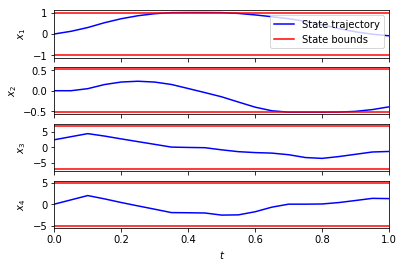

In [30]:
plot_state_trajectory(sol['primal']['x'], h, (x_min, x_max))

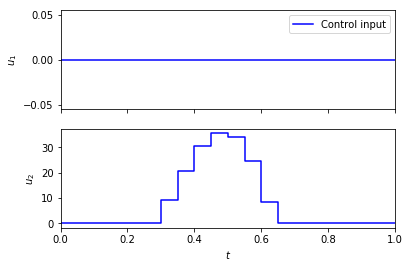

In [13]:
plot_input_sequence(sol['primal']['sc'], h)
# plt.savefig('forces.pdf')

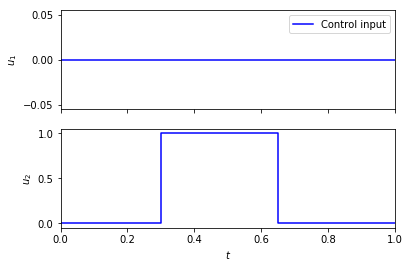

In [14]:
plot_input_sequence(sol['primal']['sb'], h)
# plt.savefig('binaries.pdf')

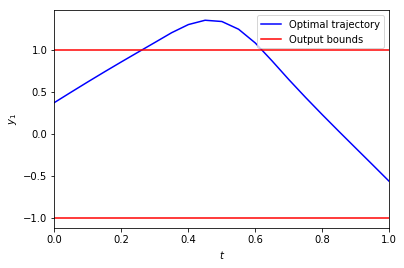

In [15]:
# output (horizontal position of the tip of the pole)
C = np.array([[1., -l, 0., 0.]])
y_min = np.array([-d])
y_max = np.array([d])
plot_output_trajectory(C, sol['primal']['x'], h, (y_min, y_max))
plt.savefig('output.pdf')

# solve in closed loop

In [ ]:
np.random.seed(1)
e_max = 0.001
N_sim = 100
u_sim = []
e_sim = []
x_sim = [x0]
warm_start = None
for t in range(N_sim):
    print('Time step ' + str(t) + '.\r'),
    cost, sol, leaves = controller.feedforward(
        x_sim[-1],
        warm_start=warm_start,
        printing_period=None,
        tree_file_name=None,
    )
    u_sim.append(sol['primal']['uc'][0])
    e_sim.append(e_max * np.random.randn(MLD.nx))
    x_sim.append(sol['primal']['x'][1] + e_sim[-1])
#     print cost
#     print len(leaves)
    
    stage_variables = {
        'x_0' : sol['primal']['x'][0],
        'uc_0' : sol['primal']['uc'][0],
        'ub_0' : sol['primal']['ub'][0],
        'sc_0' : sol['primal']['sc'][0],
        'sb_0' : sol['primal']['sb'][0],
        'e_0' : e_sim[-1]
    }
#     print e_sim[-1]
#     print x_sim[-1]
#     warm_start = controller.construct_warm_start(leaves, stage_variables)

In [ ]:
plot_input_sequence(e_sim, h, (-e_max*np.ones(MLD.nx), e_max*np.ones(MLD.nx)))
plt.show()
plot_input_sequence(u_sim, h, (u_min, u_max))
plt.show()
plot_state_trajectory(x_sim, h, (x_min, x_max))
plt.show()